In [16]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
%matplotlib inline

In [39]:
class model_state:
    def __init__(self, infile, tidx, latidx, lonidx):
        thickvarlist = [
            'h_pre_sync', 'diabatic_diff_h', 'boundary_forcing_h',
            'frazil_h', 'vert_remap_h', 'dynamics_h']
        heatvarlist = [
            'opottemptend', 'opottemppmdiff', 'opottempdiff',
            'frazil_heat_tendency', 'Th_tendency_vert_remap',
            'T_advection_xy', 'boundary_forcing_heat_tendency']
        saltvarlist = [
            'osalttend', 'osaltpmdiff', 'osaltdiff',
            'Sh_tendency_vert_remap',
            'S_advection_xy', 'boundary_forcing_salt_tendency']
        thicktendlist = [
            'dhdt','boundary_forcing_h_tendency','vert_remap_h_tendency',
            'dynamics_h_tendency']
        invars = Dataset(infile).variables
        self.thickness = dict([ (var, invars[var][tidx,:,latidx,lonidx]) for var in thickvarlist])        
        self.heattend =  dict([ (var, invars[var][tidx,:,latidx,lonidx]) for var in heatvarlist])
        self.salttend =  dict([ (var, invars[var][tidx,:,latidx,lonidx]) for var in saltvarlist])
        self.thicktend = dict([ (var, invars[var][tidx,:,latidx,lonidx]) for var in thicktendlist])
        
        # Calculate the difference between left and right hand sides
        self.heattend['residual'] = self.heattend['opottemptend'].copy()
        self.heattend['rhs'] = self.heattend['opottemppmdiff'].copy()*0.
        for k in range(1,len(heatvarlist)):
            self.heattend['residual'] -= self.heattend[heatvarlist[k]]
            self.heattend['rhs'] += self.heattend[heatvarlist[k]]
        self.heattend['rhs'] = -self.heattend['rhs']
        
        Dataset(infile).close()
class model_integrated_state:
    def __init__(self, infile, tidx):
        thickvarlist = [
            'h_pre_sync', 'diabatic_diff_h', 'boundary_forcing_h',
            'frazil_h', 'vert_remap_h', 'dynamics_h']
        heatvarlist = [
            'opottemptend', 'opottemppmdiff', 'opottempdiff',
            'frazil_heat_tendency', 'Th_tendency_vert_remap',
            'T_advection_xy', 'boundary_forcing_heat_tendency']        
        thicktendlist = [
            'dhdt','boundary_forcing_h_tendency','vert_remap_h_tendency',
            'dynamics_h_tendency']
        invars = Dataset(infile).variables                
        self.heattend =  dict([ (var, invars[var][tidx,:,:,:])  for var in heatvarlist])        
        # Calculate the difference between left and right hand sides
        self.heattend['rhs'] = self.heattend['opottemppmdiff'] + self.heattend['opottempdiff'] \
                             + self.heattend['frazil_heat_tendency'] \
                             + self.heattend['Th_tendency_vert_remap'] + self.heattend['T_advection_xy'] \
                             + self.heattend['boundary_forcing_heat_tendency']
        self.heattend['abs_residual_2d'] = np.abs(self.heattend['opottemptend'] - self.heattend['rhs']).sum(axis=0)
        
                
        Dataset(infile).close()              
        
def plot_cum_integral(h, var, label, ls = 'x-', lw=2):
    depth =  (h).cumsum()
    cumint = (var).cumsum()
    plt.plot(cumint, depth, ls, linewidth = lw, label=label)    
    
def compare_integrals(thickname, varname, native, remapped):    
    plot_cum_integral(native.thickness[thickname], 
                  native.heattend[varname], 'Native', lw = 4)
    plot_cum_integral(remapped.thickness[thickname], 
                  remapped.heattend[varname], 'Remapped', ls = 'o-')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(varname)

In [42]:
tidx = -1 ; latidx = 100; lonidx = 75
figsize = (12,12)
modelpath = '/work/aes/OM4_05/heat_budget/'
nativepath = modelpath + '19000101.tendency_native.nc'
remappedpath = modelpath + '19000101.tendency_z.nc'
gridpath = '/work/aes/OM4_05/ocean_annual.static.nc'
geolon = Dataset(gridpath).variables['geolon']
geolat = Dataset(gridpath).variables['geolat']
native_state = model_state(nativepath, tidx, latidx, lonidx)
remapped_state = model_state(remappedpath, tidx, latidx, lonidx)
remapped_integrated_state = model_integrated_state(remappedpath,tidx)

# Check remapped tendencies
The native and remapped diagnostics are validated against each other by plotting their cumulative integrals from the surface at a given point. Change tidx, latidx, and lonidx above to change the plotting location.

## Heat tendencies

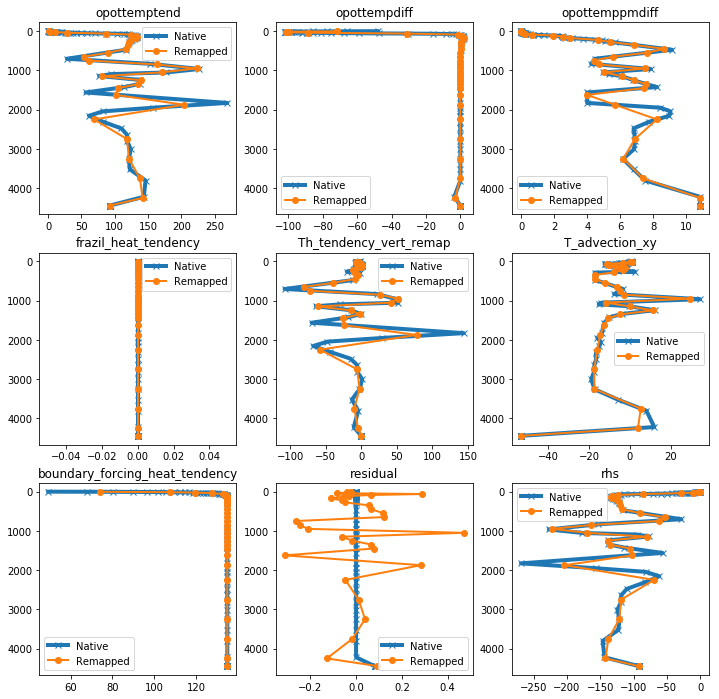

In [43]:
plt.figure(figsize=figsize) 
pltidx = 330
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('h_pre_sync', 'opottemptend', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('diabatic_diff_h', 'opottempdiff', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('h_pre_sync', 'opottemppmdiff', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('frazil_h', 'frazil_heat_tendency', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('vert_remap_h', 'Th_tendency_vert_remap', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('dynamics_h', 'T_advection_xy', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('boundary_forcing_h', 'boundary_forcing_heat_tendency', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('h_pre_sync', 'residual', native_state, remapped_state)
pltidx += 1 ; plt.subplot(pltidx)
compare_integrals('h_pre_sync', 'rhs', native_state, remapped_state)

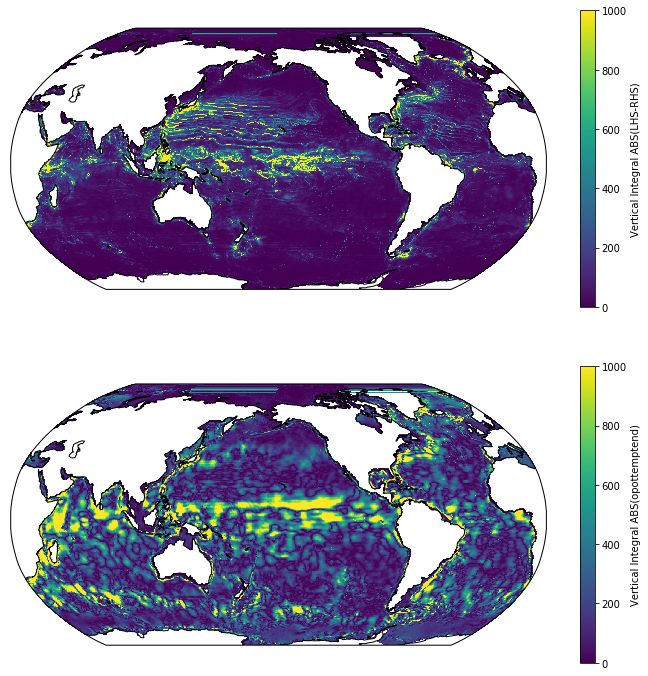

In [44]:
plt.figure(figsize = (12,12))
ax1 = plt.subplot(2,1,1,projection=ccrs.Robinson(central_longitude=(20+380)*0.5))
im = ax1.pcolormesh(geolon,geolat,remapped_integrated_state.heattend['abs_residual_2d'],transform = ccrs.PlateCarree(),vmin=0,vmax=1000.)
cax = plt.colorbar(im)
cax.set_label('Vertical Integral ABS(LHS-RHS)')
ax1.coastlines()
ax2 = plt.subplot(2,1,2,projection=ccrs.Robinson(central_longitude=(20+380)*0.5))
im = ax2.pcolormesh(geolon,geolat,np.abs(remapped_integrated_state.heattend['opottemptend'].sum(axis=0)),transform = ccrs.PlateCarree(),vmin = 0., vmax= 1000)
ax2.coastlines()
cax = plt.colorbar(im)
cax.set_label('Vertical Integral ABS(opottemptend)')